CUDA Convolutional Sparse Coding with Gradient Term
===================================================

This example demonstrates the use of the interface to the CUDA CSC solver extension package, with a test for the availablity of a GPU that runs the Python version of the ConvBPDNGradReg solver if one is not available, or if the extension package is not installed.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import plot
plot.config_notebook_plotting()
from sporco import cuda
from sporco.admm import cbpdn
import sporco.linalg as spl
import sporco.metric as spm

# If running in a notebook, try to use wurlitzer so that output from the CUDA
# code will be properly captured in the notebook.
from contextlib import contextmanager
@contextmanager
def null_context_manager():
    yield
if util.in_notebook():
    try:
        from wurlitzer import sys_pipes
    except:
        sys_pipes = null_context_manager
else:
    sys_pipes = null_context_manager

Load example image.

In [2]:
img = util.ExampleImages().image('barbara.png', scaled=True, gray=True,
                                 idxexp=np.s_[10:522, 100:612])

Load main dictionary and prepend an impulse filter for lowpass component representation.

In [3]:
Db = util.convdicts()['G:12x12x36']
di = np.zeros(Db.shape[0:2] + (1,), dtype=np.float32)
di[0, 0] = 1
D = np.concatenate((di, Db), axis=2)

Set up weights for the $\ell_1$ norm to disable regularization of the coefficient map corresponding to the impulse filter.

In [4]:
wl1 = np.ones((1,)*2 + (D.shape[2:]), dtype=np.float32)
wl1[..., 0] = 1e-15  # Not set to zero due to a bug in sporco-cuda

Set of weights for the $\ell_2$ norm of the gradient to disable regularization of all coefficient maps except for the one corresponding to the impulse filter.

In [5]:
wgr = np.zeros((D.shape[2]), dtype=np.float32)
wgr[0] = 1.0

Set up [admm.cbpdn.ConvBPDNGradReg](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNGradReg) options.

In [6]:
lmbda = 1e-2
mu = 5e-1
opt = cbpdn.ConvBPDNGradReg.Options({'Verbose': True, 'MaxMainIter': 250,
                    'HighMemSolve': True, 'RelStopTol': 5e-3,
                    'AuxVarObj': False, 'AutoRho': {'Enabled': False},
                    'rho': 0.5, 'L1Weight': wl1, 'GradWeight': wgr})

If GPU available, run CUDA ConvBPDNGradReg solver, otherwise run standard Python version.

In [7]:
if cuda.device_count() > 0:
    print('%s GPU found: running CUDA solver' % cuda.device_name())
    tm = util.Timer()
    with sys_pipes(), util.ContextTimer(tm):
        X = cuda.cbpdngrd(D, img, lmbda, mu, opt)
    t = tm.elapsed()
else:
    print('GPU not found: running Python solver')
    c = cbpdn.ConvBPDNGradReg(D, img, lmbda, mu, opt)
    X = c.solve().squeeze()
    t = c.timer.elapsed('solve')
print('Solve time: %.2f s' % t)

Tesla K40c GPU found: running CUDA solver


Itn   Fnc       DFid      Regℓ1     Regℓ2∇     r         s         ρ
--------------------------------------------------------------------------
   1  6.80e+03  6.30e+03  5.00e+04  4.21e-01  4.45e-01  9.62e+00  5.00e-01
   2  7.23e+02  2.56e+02  4.66e+04  2.10e+00  1.19e-01  2.31e+00  5.00e-01
   3  3.78e+02  1.55e+01  3.61e+04  3.32e+00  6.03e-02  7.74e-01  5.00e-01
   4  2.97e+02  5.74e+00  2.89e+04  4.52e+00  4.54e-02  5.17e-01  5.00e-01
   5  2.42e+02  3.56e+00  2.36e+04  5.92e+00  3.62e-02  4.06e-01  5.00e-01
   6  2.07e+02  3.06e+00  2.00e+04  7.31e+00  2.99e-02  3.37e-01  5.00e-01
   7  1.78e+02  2.91e+00  1.71e+04  8.73e+00  2.48e-02  2.88e-01  5.00e-01
   8  1.57e+02  2.85e+00  1.49e+04  1.02e+01  2.08e-02  2.55e-01  5.00e-01
   9  1.39e+02  2.76e+00  1.30e+04  1.16e+01  1.76e-02  2.27e-01  5.00e-01
  10  1.25e+02  2.71e+00  1.16e+04  1.30e+01  1.51e-02  2.04e-01  5.00e-01
  11  1.14e+02  2.67e+00  1.04e+04  1.43e+01  1.31e-02  1.83e-01  5.00e-01
  12  1.06e+02  2.67e+00  9.52e

Solve time: 1.57 s


Reconstruct the image from the sparse representation.

In [8]:
imgr = np.sum(spl.fftconv(D, X), axis=2)
print("Reconstruction PSNR: %.2fdB\n" % spm.psnr(img, imgr))

Reconstruction PSNR: 45.66dB



Display representation and reconstructed image.

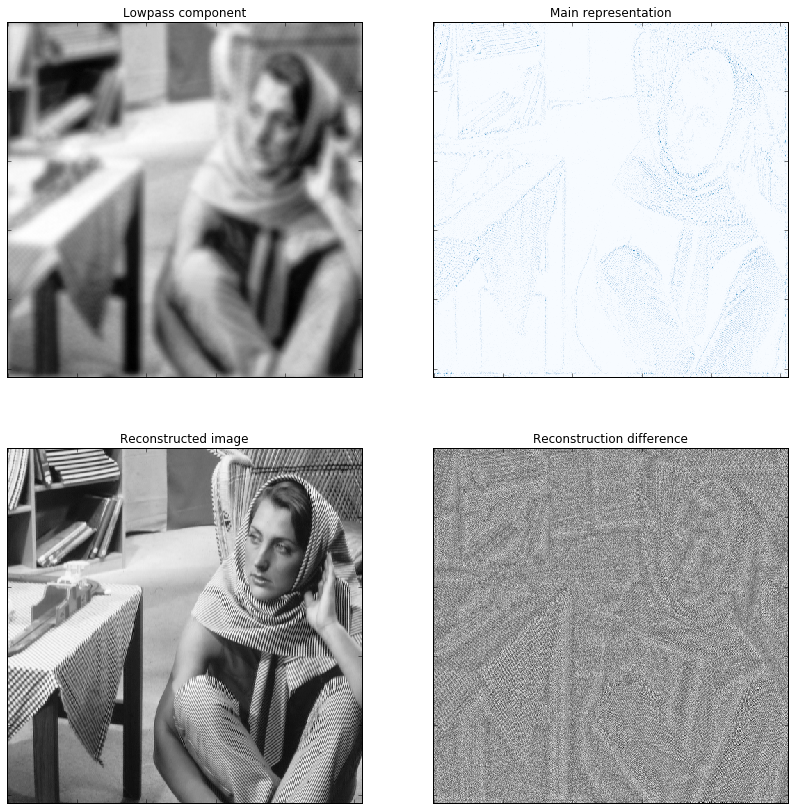

In [9]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(X[..., 0].squeeze(), fig=fig, title='Lowpass component')
plot.subplot(2, 2, 2)
plot.imview(np.sum(abs(X[..., 1:]), axis=2).squeeze(), fig=fig,
            cmap=plot.cm.Blues, title='Main representation')
plot.subplot(2, 2, 3)
plot.imview(imgr, fig=fig, title='Reconstructed image')
plot.subplot(2, 2, 4)
plot.imview(imgr - img, fig=fig, fltscl=True,
            title='Reconstruction difference')
fig.show()